In [ ]:
"""
Author: Ryleigh J. Bruce
Date: June 4, 2024

Purpose: To sort through a directory of images and copy files over to a new folder based on a specific string in the file name. A text file containing a list of all of the copied files is produced alongside the folder.


Note: The author generated this text in part with GPT-4,
OpenAI’s large-scale language-generation model. Upon generating
draft code, the authors reviewed, edited, and revised the code
to their own liking and takes ultimate responsibility for
the content of this code.

"""

# Overview

This notebook describes methods for filtering, organizing, and reviewing large collections of image files based on specific criteria embedded in their filenames. The primary purpose is to automate the process of identifying images that match user-defined strings—such as species names, dates, or camera locations—within a directory, and then copy those files to a new destination folder.

# Critical Uses & Adaptability

## What the Notebooks Can Be Used For:

- Exploration and filtering of large image datasets based on filename patterns: this is useful for curating datasets for specific analyses or experiments, and for quickly assessing the distribution of images matching certain criteria.
- File management, data filtering, and visualization in the context of image datasets: this is useful for automating repetitive tasks.
- By filtering images according to embedded metadata in filenames, datasets can be prepared for feature extraction or downstream analysis. The approach can be extended to select images with particular attributes relevant to research questions.

## How the Notebook Can Be Adapted:

- The workflow can be adapted for projects involving spatial analysis or architectural site studies by modifying the search parameters to reflect spatial features, site codes, or architectural elements present in filenames. This supports organization and review of spatially referenced image collections.
- The notebook can be used with different datasets by changing the `source_directory` and `destination_directory` variables.

### Install Dependncies & Environment Setup

Import all required libraries and set up configuration variables that will be used throughout the notebook. This module sets up the working environment with all the tools needed for downloading data from Borealis, handling zip files through the `zipfile` library, processing images, and creating visualizations through the `matplotlib.pyplot`. The `public_doi` points to the specific dataset this notebook will be working with in the Borealis database. The data is hosted in the University of Manitoba Dataverse (https://borealisdata.ca/dataverse/manitoba), a research data repository. The images used in this notebook were collected as part of the 'Understanding Animals' project at University of Manitoba Faculty of Architecture, online at [Wild Winnipeg](https://www.wildwinnipeg.org/) and [Teaching with Images](https://pressbooks.openedmb.ca/teachingwithimages/).

In [9]:
# Import all required libraries
import os
import shutil
import random
import requests
import zipfile
from PIL import Image
import matplotlib.pyplot as plt

# Borealis API configuration
BOREALIS_SERVER = "https://borealisdata.ca"
public_doi = "doi:10.5683/SP3/H3HGWF"

print("✅ All libraries imported and configuration set")

✅ All libraries imported and configuration set


### Borealis Database Repository Functions

This module creates the connection to Borealis data repository. The `get_public_dataset_info()` function gets a list of all files in a dataset, and the `download_public_file()` code block downloads a specific file by its ID. These functions handle the technical details of API communication and file downloading.

In [10]:
def get_public_dataset_info(persistent_id):
    """Get information about a public dataset"""
    url = f"{BOREALIS_SERVER}/api/datasets/:persistentId/"
    params = {"persistentId": persistent_id}

    response = requests.get(url, params=params)

    if response.status_code == 200:
        dataset_info = response.json()
        files_list = dataset_info['data']['latestVersion']['files']

        file_info_list = []
        for file_info in files_list:
            file_id = file_info['dataFile']['id']
            filename = file_info['dataFile']['filename']
            file_info_list.append({"file_id": file_id, "filename": filename})

        return file_info_list
    else:
        print(f"Cannot access dataset: {response.status_code}")
        return None

def download_public_file(file_id, save_path="./"):
    """Download a specific public file from a dataset by its file ID"""
    url = f"{BOREALIS_SERVER}/api/access/datafile/{file_id}"

    response = requests.get(url, stream=True)

    if response.status_code == 200:
        filename = None
        if "Content-Disposition" in response.headers:
            cd = response.headers["Content-Disposition"]
            if "filename=" in cd:
                filename = cd.split("filename=")[1].strip('"')

        if not filename:
             filename = url.split("/")[-1]

        file_path = f"{save_path}/{filename}"

        with open(file_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"✅ File downloaded to {file_path}")
        return file_path
    else:
        print(f"❌ Error {response.status_code}: File may be restricted or not found")
        return None

print("✅ Borealis API functions defined")

✅ Borealis API functions defined


### File Management & Extracting Zipped Data

When you download a zip file, images might be buried several folders deep. The `find_image_directory()` function automatically searches through all folders to find where the actual images are stored. This module handles data by using an `if` statement to loop through the zipped contents using the `zip_ref.infolist()` and the `zip_ref.extractall(extract_path)` to extract files, which all works under the `unzip_file()` code block.

In [11]:
def is_zip_file(filepath):
    """Checks if a file is a valid zip file"""
    return zipfile.is_zipfile(filepath)

def unzip_file(filepath, extract_path="./"):
    """Unzips a zip file and returns the top-level extracted folder name"""
    if is_zip_file(filepath):
        try:
            with zipfile.ZipFile(filepath, 'r') as zip_ref:
                top_level_folder = None
                for file_info in zip_ref.infolist():
                    parts = file_info.filename.split('/')
                    if parts[0] and len(parts) > 1:
                        top_level_folder = parts[0]
                        break

                zip_ref.extractall(extract_path)
                print(f"✅ Successfully unzipped {filepath} to {extract_path}")
                return top_level_folder

        except Exception as e:
            print(f"❌ Error unzipping {filepath}: {e}")
            return None
    else:
        print(f"ℹ️ {filepath} is not a valid zip file.")
        return None

def find_image_directory(base_path):
    """Find the directory containing the most image files"""
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.tif', '.JPG'}
    best_dir = None
    max_images = 0

    for root, dirs, files in os.walk(base_path):
        image_count = sum(1 for f in files if os.path.splitext(f.lower())[1] in image_extensions)
        if image_count > max_images:
            max_images = image_count
            best_dir = root

    return best_dir, max_images

print("✅ File handling functions defined")

✅ File handling functions defined


### Image Processing & Visualization Functions

 `filter_and_copy_images()` searches through thousands of images, finding ones that match your criteria (like containing "raccoon" in the filename), and copying them to organized folders. This can be customized to fit specific datasets that one may wish to subtitute for their own use.

 The `display_image_grid()` produces a visual preview of the file handling, showing up to 15 random images in a neat grid layout.

In [12]:
def filter_and_copy_images(source_directory, destination_directory, output_text_file, search_term, description="images"):
    """Filter and copy images based on a search term in the filename"""
    os.makedirs(destination_directory, exist_ok=True)

    images = []

    with open(output_text_file, "w") as file:
        for dirpath, dirnames, filenames in os.walk(source_directory):
            for filename in filenames:
                if search_term in filename.lower() and filename.lower().endswith(('.png', '.jpg', '.jpeg', '.JPG')):
                    full_file_path = os.path.join(dirpath, filename)
                    images.append(full_file_path)
                    file.write(filename + "\n")

                    try:
                        shutil.copy(full_file_path, os.path.join(destination_directory, filename))
                    except Exception as e:
                        print(f"Failed to copy {filename}. Reason: {str(e)}")

    print(f"Found and copied {len(images)} {description}.")
    return images

def display_image_grid(images, title="Images", subset_size=15):
    """Display a grid of images from the provided list"""
    if len(images) == 0:
        print(f"No {title.lower()} to display.")
        return

    selected_files_subset = random.sample(images, min(subset_size, len(images)))

    fig = plt.figure(figsize=(20, 10))
    columns = 5
    rows = 3

    for i, file_path in enumerate(selected_files_subset):
        try:
            img = Image.open(file_path)
            ax = fig.add_subplot(rows, columns, i + 1)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(os.path.basename(file_path), fontsize=8, pad=5)
        except Exception as e:
            print(f"Error displaying image {os.path.basename(file_path)}: {e}")

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.tight_layout(pad=1)
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

print("✅ Image processing functions defined")

✅ Image processing functions defined


The module uses `os.makedirs(..., exist_ok=True)` to safely create the destination folder, `os.walk()` to recursively scan subdirectories, and a combined condition with in and `.endswith()` to filter files by search term and extension. Matching filenames are written with `file.write()`, and `shutil.copy()` is used to duplicate the files. Then, in order to display the images, the `random.sample()` line is used to select the images, while `plt.figure()` and a subplot layout prepares the display. The `Image.open()` and `ax.imshow()` functions then renders each image, and the `ax.axis('off')` hides the axes, while the `plt.subplots_adjust()` with `plt.suptitle()` handles final layout and title formatting.

### Dataset Download and Preparation

This module uses `calling get_public_dataset_info()` to retrieve all dataset files and initialize tracking variables. It loops through the list to find '4370-entire-subset.zip' via a filename comparison, then uses `download_public_file()` to fetch it.

The file is verified and extracted with `unzip_file()`, after which `os.path.join()` and `find_image_directory()` locate the actual images. The source_directory variable is then set for use by filtering functions. If no images are found, `os.walk()` outputs the folder hierarchy for debugging, and a final check ensures that the `source_directory` is ready before any filtering steps run.

In [13]:
# Download the 4370-entire-subset.zip file
dataset_files = get_public_dataset_info(public_doi)
subset_file_id = None
source_directory = None

for file_info in dataset_files:
    if file_info['filename'] == '4370-entire-subset.zip':
        subset_file_id = file_info['file_id']
        break

if subset_file_id:
    print("Downloading 4370-entire-subset.zip...")
    downloaded_file = download_public_file(subset_file_id, "./")

    if downloaded_file and is_zip_file(downloaded_file):
        extracted_folder = unzip_file(downloaded_file, "./")

        if extracted_folder:
            base_extracted_path = os.path.join('./', extracted_folder)
            image_dir, image_count = find_image_directory(base_extracted_path)

            if image_dir and image_count > 0:
                source_directory = image_dir
                print(f"Found {image_count} images in: {source_directory}")
            else:
                print(f"No images found in extracted folder: {base_extracted_path}")
                print("Directory structure:")
                for root, dirs, files in os.walk(base_extracted_path):
                    level = root.replace(base_extracted_path, '').count(os.sep)
                    indent = ' ' * 2 * level
                    print(f"{indent}{os.path.basename(root)}/")
                    subindent = ' ' * 2 * (level + 1)
                    for file in files[:5]:
                        print(f"{subindent}{file}")
else:
    print("❌ Could not find 4370-entire-subset.zip in the dataset")

# Store source_directory for use in subsequent cells
if source_directory:
    print(f"✅ Ready to filter images from: {source_directory}")
else:
    print("❌ Source directory not found - cannot proceed with filtering")

✅ File downloaded to .//965304
✅ Successfully unzipped .//965304 to ./
Found 4370 images in: ./4370-new-subset2
✅ Ready to filter images from: ./4370-new-subset2


## File Search Based on Species

### Animal Speces Image Filter

The first filtering task uses the `filter_and_copy_images()` with the `source_directory` as input, a `./image-filter/racoons` folder for output, a text log file for matching filenames, and `'raccoon'` as the case-insensitive search term. Finally, `display_image_grid()` is called to show up to 15 random raccoon images in a visual grid.

These parameters can be customized to different animal species.

=== Filtering Raccoon Images ===
Found and copied 595 raccoon images.


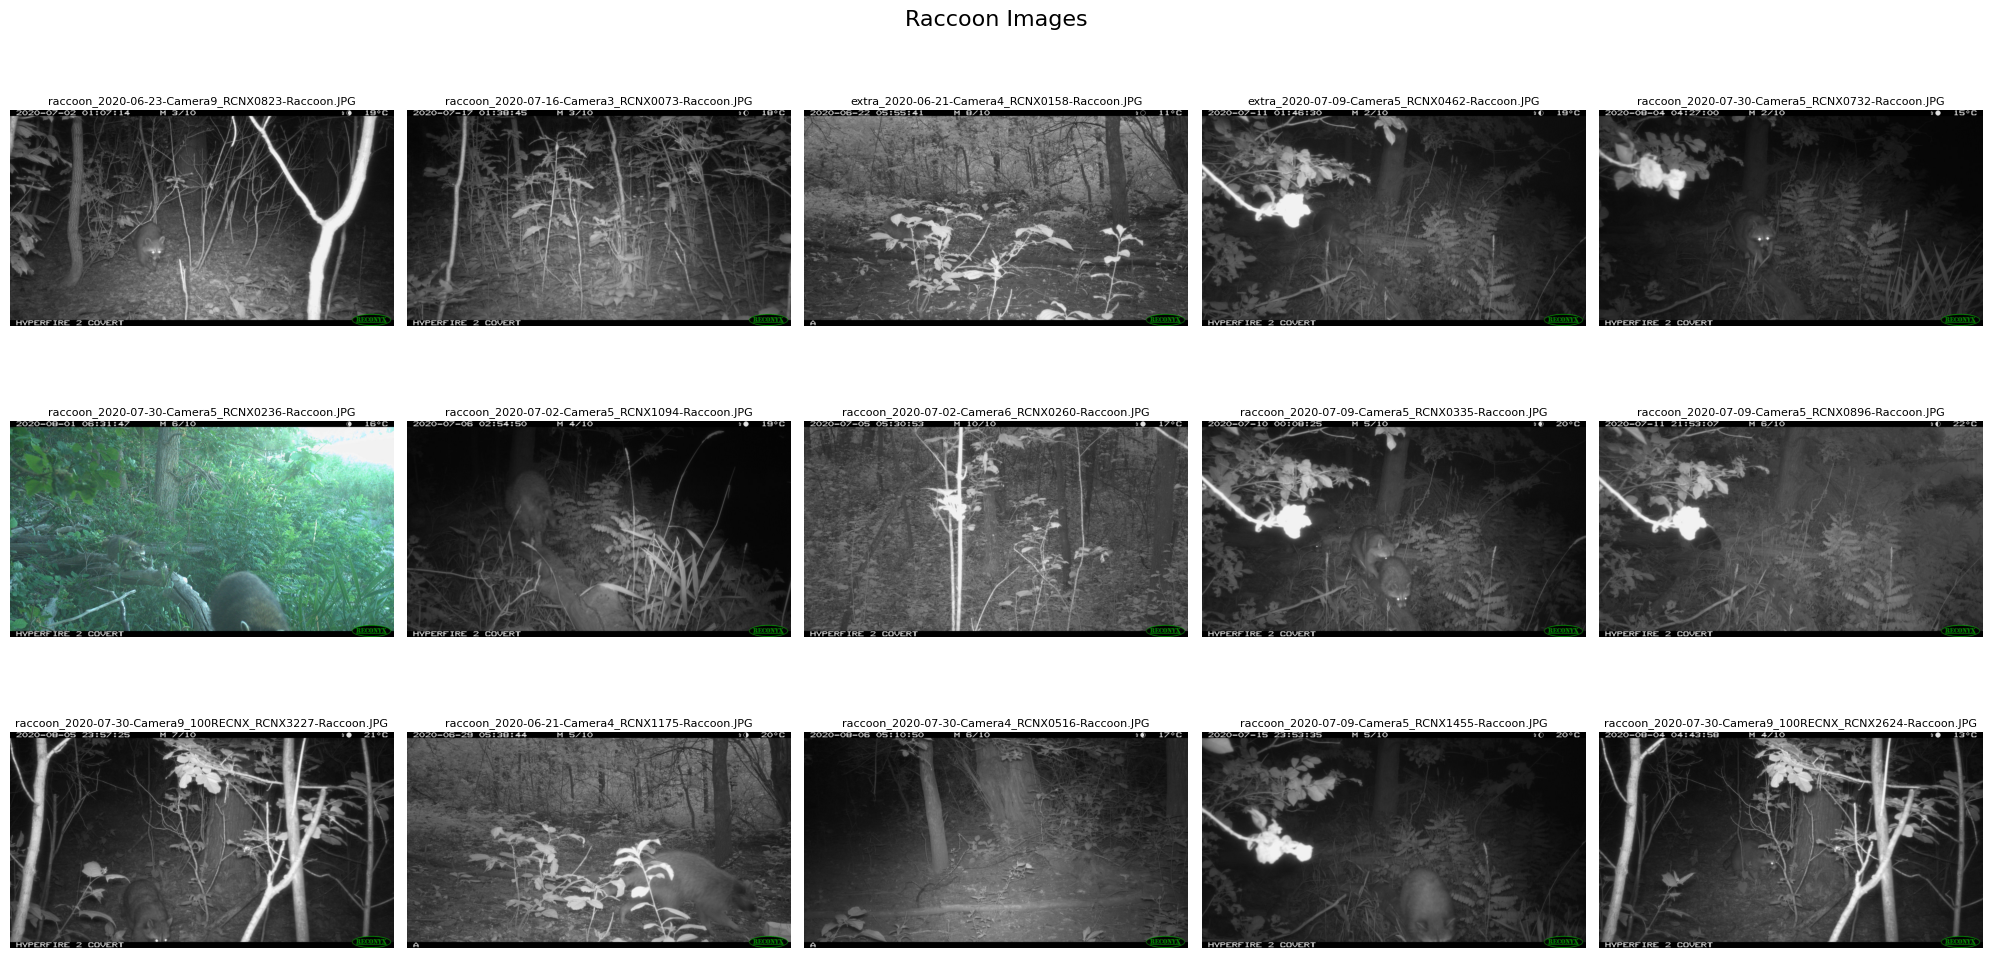

In [14]:
if 'source_directory' in globals() and source_directory:
    # Filter 1: Raccoon images
    print("=== Filtering Raccoon Images ===")
    raccoon_images = filter_and_copy_images(
        source_directory=source_directory,
        destination_directory="./image-filter/racoons",
        output_text_file="./image-filter/Racoon Images.txt",
        search_term='raccoon',
        description="raccoon images"
    )
    display_image_grid(raccoon_images, "Raccoon Images")
else:
    print("❌ Source directory not available. Run Cell 5 first.")

## File Search Based on Date

### Date-Specific Image Filter

The second filtering task focuses on the dates of the camera trap image files. The code repeats the safety check to confirm source_directory exists, then calls `filter_and_copy_images()` with parameters for a date-specific search. The output folder is `./image-filter/June 3rd 2020`, the text log matches the folder name, and the search term `"2020-06-03"` filters filenames containing that date in ISO format. Finally, `display_image_grid()` shows images from that day, useful for spotting daily activity patterns or specific events.

These parameters can again be changed to fit your own datasets that are date-specific.

=== Filtering June 3rd 2020 Images ===
Found and copied 194 June 3rd 2020 images.


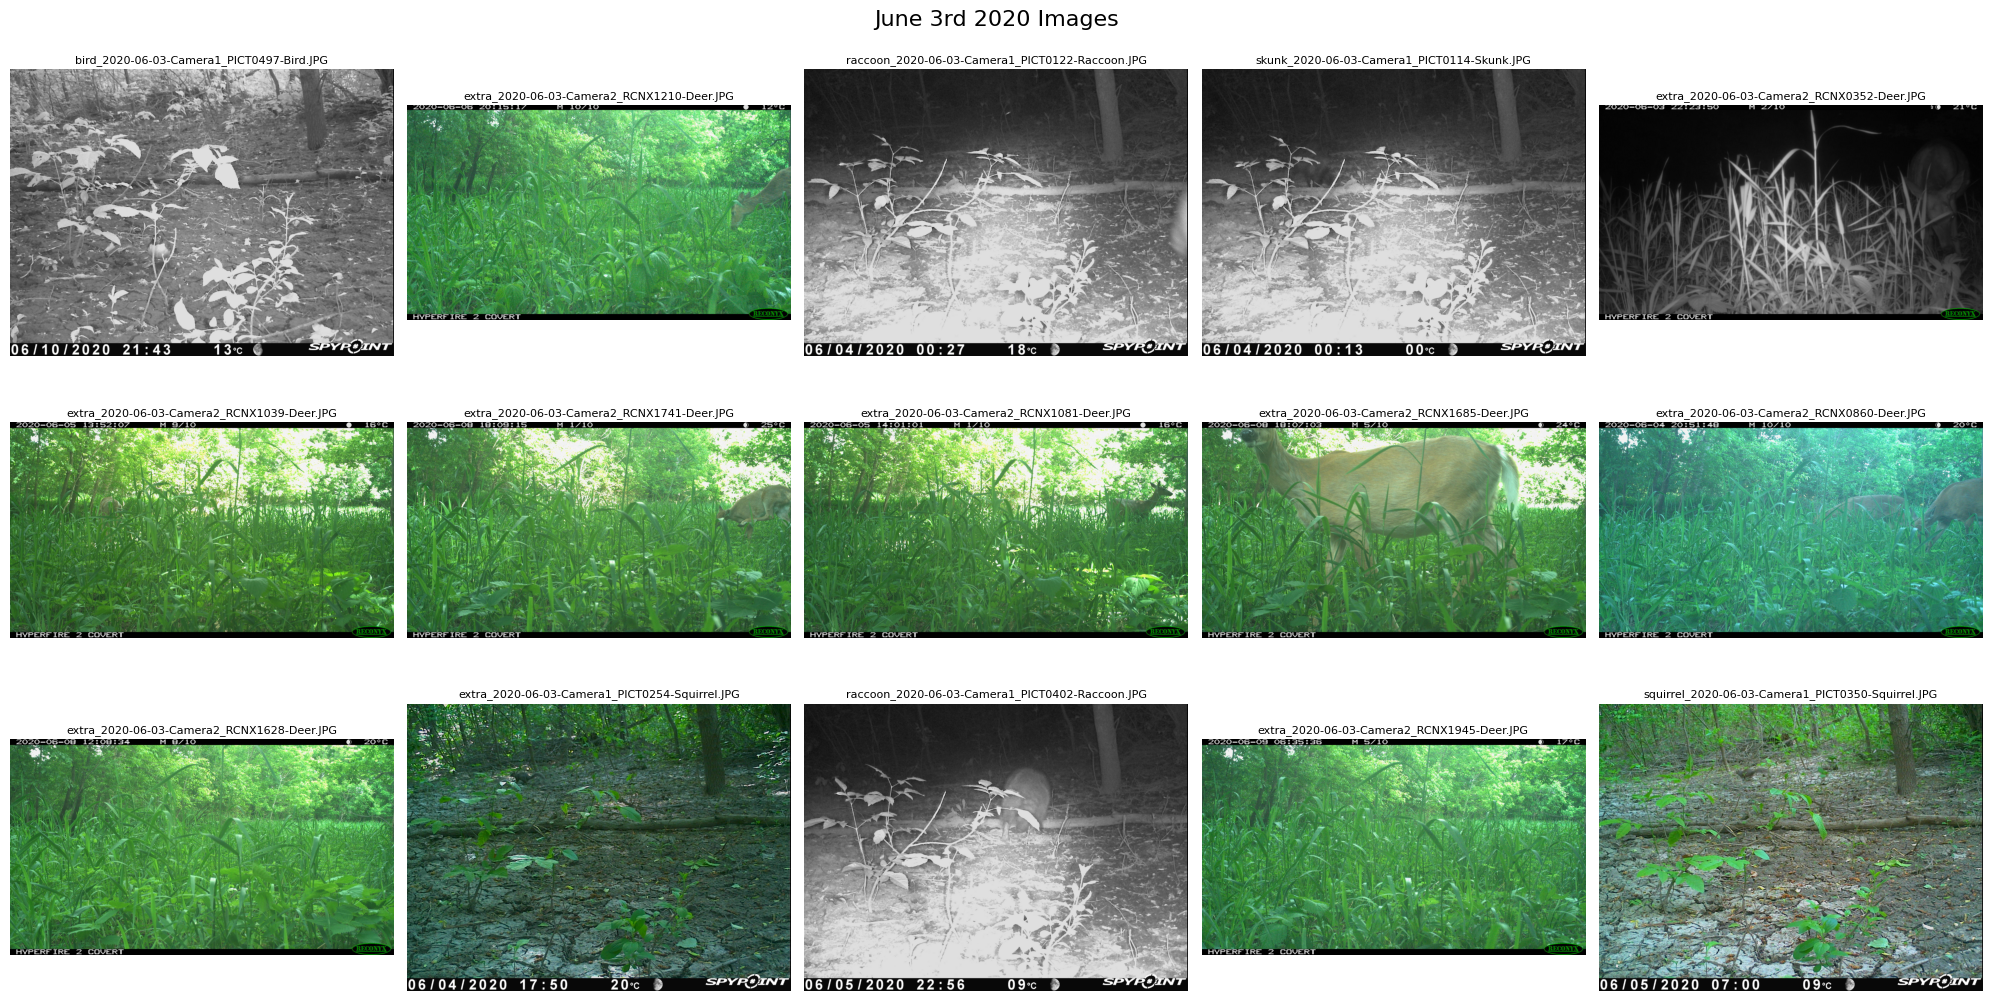

In [15]:
if 'source_directory' in globals() and source_directory:
    # Filter 2: June 3rd 2020 images
    print("=== Filtering June 3rd 2020 Images ===")
    june_images = filter_and_copy_images(
        source_directory=source_directory,
        destination_directory='./image-filter/June 3rd 2020',
        output_text_file='./image-filter/June 3rd 2020 Images.txt',
        search_term="2020-06-03",
        description="June 3rd 2020 images"
    )
    display_image_grid(june_images, "June 3rd 2020 Images")
else:
    print("❌ Source directory not available. Run Cell 5 first.")

## FIle Search based on Location

### Camera Location Filter

The last example is filtering the dataset based on camera trap location. This snippet of code performs the same safety check to ensure `source_directory exists`, then calls `filter_and_copy_images()` with camera-specific settings. The output folder is `./image-filter/camera2`, the text log is stored inside that folder, and the search term `"camera2"` filters filenames for that camera. Finally, `display_image_grid()` provides a quick visual overview of this camera’s captures, useful for comparing locations or evaluating performance.

These parameters can continue to be adjusted based on ones own dataset of files that are assigned location IDs.

=== Filtering Camera2 Images ===
Found and copied 907 camera2 images.


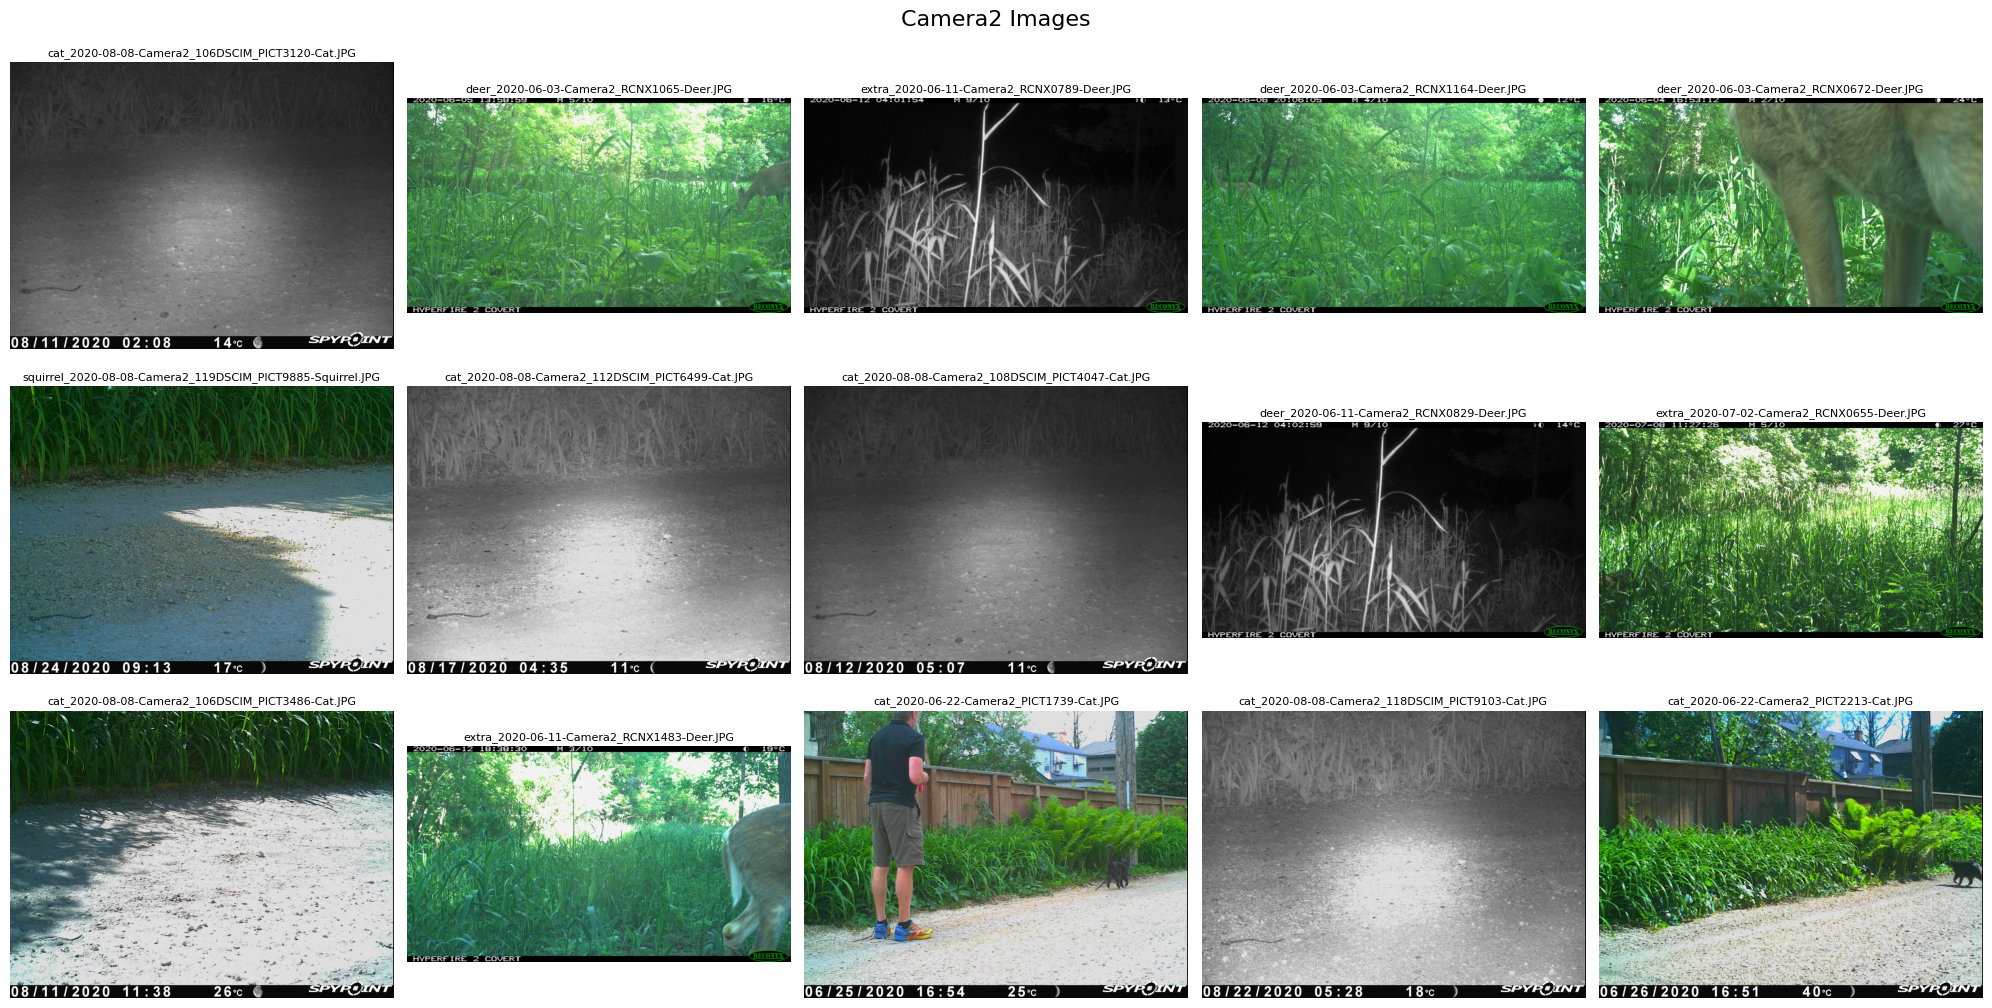

In [16]:
if 'source_directory' in globals() and source_directory:
    # Filter 3: Camera2 images
    print("=== Filtering Camera2 Images ===")
    camera2_images = filter_and_copy_images(
        source_directory=source_directory,
        destination_directory='./image-filter/camera2',
        output_text_file='./image-filter/camera2/Camera 2 Images.txt',
        search_term="camera2",
        description="camera2 images"
    )
    display_image_grid(camera2_images, "Camera2 Images")
else:
    print("❌ Source directory not available. Run Cell 5 first.")

## Adaptable Code-Block: Custom Search Filter

This block of code can be utilized for its easily adaptable variables that adhere to the search filter.

In [ ]:
# 🛠️ CUSTOMIZE THESE VARIABLES FOR YOUR SEARCH
custom_search_term = "deer"  # ⬅️ Change this to search for different animals/patterns
custom_destination = "./image-filter/custom-filter"  # ⬅️ Change output folder name
custom_description = "deer images"  # ⬅️ Change description for progress messages

# Run the custom filter
if 'source_directory' in globals() and source_directory:
    print(f"🎯 === Filtering {custom_description.title()} ===")

    # Create custom text file name based on search term
    custom_text_file = f"./image-filter/{custom_search_term.title()}-Images.txt"

    custom_images = filter_and_copy_images(
        source_directory=source_directory,
        destination_directory=custom_destination,
        output_text_file=custom_text_file,
        search_term=custom_search_term,
        description=custom_description
    )
    display_image_grid(custom_images, f"{custom_search_term.title()} Images")

    # Print summary
    print(f"📊 Summary: Found {len(custom_images)} images matching '{custom_search_term}'")
    print(f"📁 Images copied to: {custom_destination}")
    print(f"📄 List saved to: {custom_text_file}")
else:
    print("❌ Source directory not available. Run Block 5 first to download the dataset.")